<div class="pull-right">
    made by
    <a href=https://github.com/sergeimars title=sergeimars>sergeimars</a>
</div>

# Статистический анализ данных сервиса аренды самокатов GoFast

План работы следующий:

- ознакомиться со структурой данных;
- выявить проблемы в виде дубликатов, пропусков и неверных форматов, и найти оптимальные пути для их устранения;
- изучить данные на предмет аномальных значений;
- избавиться от выбросов;
- оценить объем удаленных данных, при необходимости повторить итерацию для снижения доли в случае риска искажения данных;
- провести исследовательский анализ данных, убедиться что предыдущие шаги были выполнены верно, при необходимости повторить итерацию;
- расчитать дополнительную аналитику и добавить в датафрейм;
- проверить гипотезы;
- сделать выводы по вопросам с учетом подходящего распределения вероятностей для случайной величины;
- сформировать выводы по итогам проделанной работы.

В нашем распоряжении имеются следующие данные о пользователях, их поездках и подписках:

**Пользователи** (users_go.csv):
- user_id - идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

**Поездки** (rides_go.csv):
- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

**Подписки**  (subscriptions_go.csv):
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from math import factorial
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

   ### Откроем файл с данными и изучим общую информацию. 

 #### Откроем файл и выведем первые несколько строк датафрейма

In [2]:
try:
    users_data = pd.read_csv('users_go.csv')
    rides_data = pd.read_csv('rides_go.csv')
    subs_data = pd.read_csv('subscriptions_go.csv')
except:
    print('Не получилось, нужно проверить адрес')
else:
    print('Данные загружены успешно!')

Данные загружены успешно!


Выведем информацию и первые строки датафреймов:

- Пользователи (users_go.csv):

In [3]:
display(users_data.head(), users_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


None

- Поездки (rides_go.csv):

In [4]:
display(rides_data.head(), rides_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


None

- Подписки (subscriptions_go.csv):

In [5]:
display(subs_data.head(), subs_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


None

#### Построим общую гистограмму для всех числовых столбцов таблицы

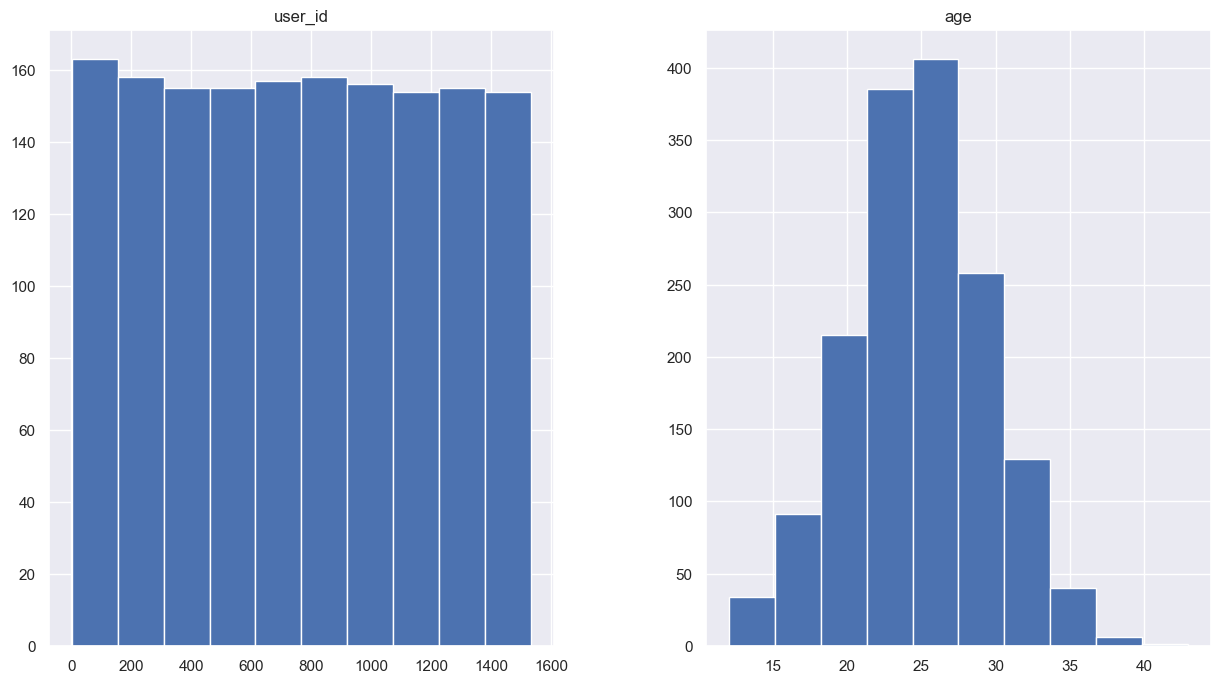

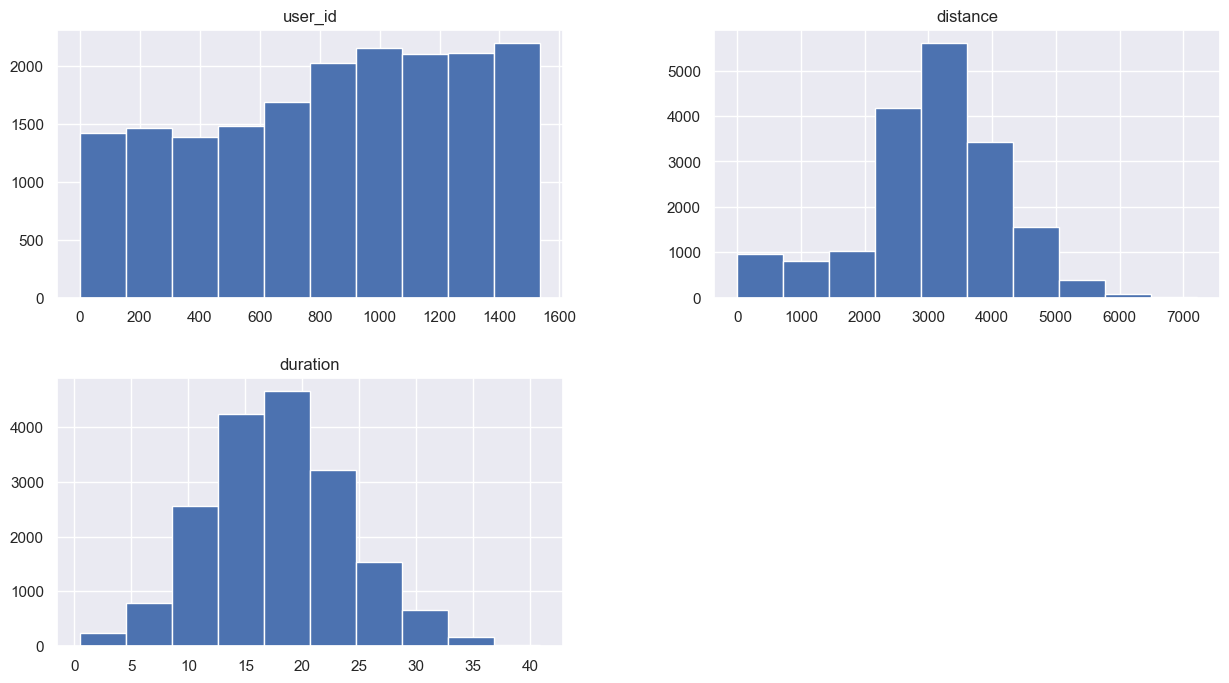

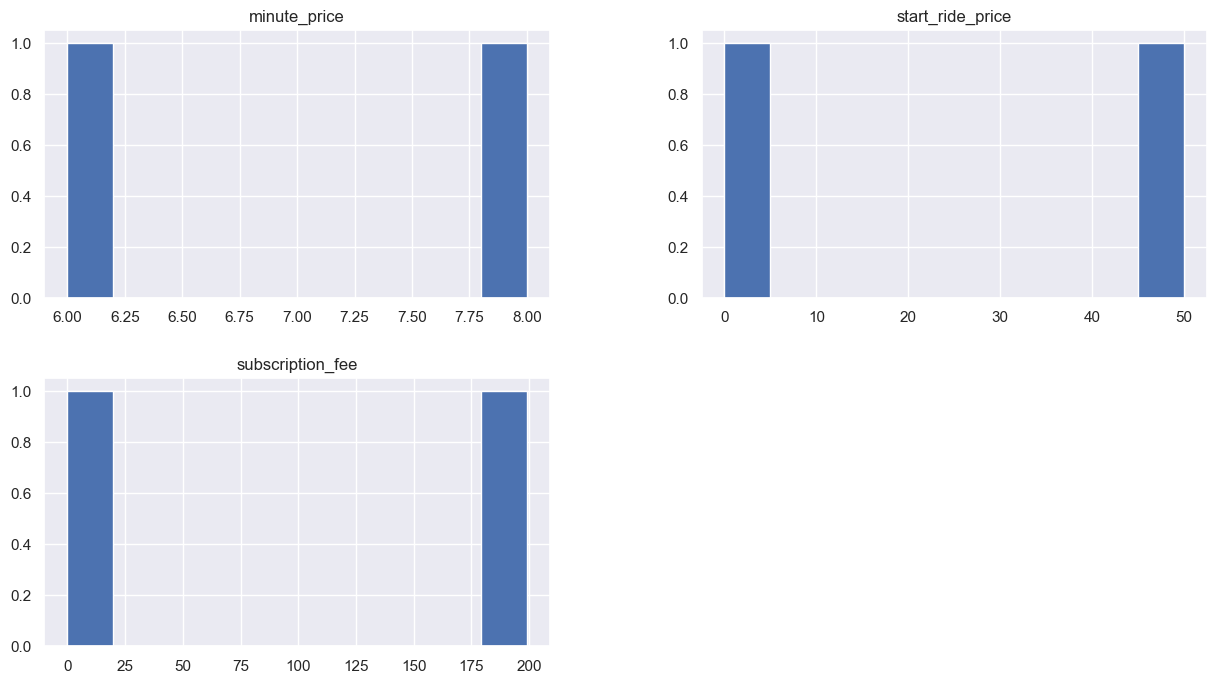

In [6]:
sns.set(rc={'figure.figsize':(15, 8)})
users_data.hist()
rides_data.hist()
subs_data.hist()
plt.show()

Приступим к предобработке

#### Вывод:

В каждой строке таблицы "Пользователи" - данные о пользователе. Часть колонок описывает имя, возраст и город, последняя колонка показывает тип подписки.
В таблице "Поездки" мы наблюдаем данные о совершенных поездках, когда и сколько проехал пользователь.
"Подписки" же содержат данные о ценовых параметров каждого типа подписки.
Предварительно, с учетом дополнительных расчетных столбцов, которые планируется добавить в процессе исследования, можно утверждать, что данных достаточно для проверки гипотез. 

Чтобы двигаться дальше, нужно устранить проблемы в данных.

### Предобработка данных

 #### Анализ дубликатов

In [7]:
print(f'Количество дубликатов в датафрейме "Пользователи": {users_data.duplicated().sum()}')
print(f'Количество дубликатов в датафрейме "Поездки": {rides_data.duplicated().sum()}')

Количество дубликатов в датафрейме "Пользователи": 31
Количество дубликатов в датафрейме "Поездки": 0


Устраним дубликаты:

In [8]:
users_data=users_data.drop_duplicates()
print(f'Количество дубликатов в датафрейме "Пользователи": {users_data.duplicated().sum()}')

Количество дубликатов в датафрейме "Пользователи": 0


Также проверим датасеты на предмет неявных дубликатов. Наиболее вероятны дубликаты по столбцу 'city' и 'subscription_type' в датафрейме "Пользователи":

In [9]:
print(users_data['city'].sort_values().unique())
print(users_data['subscription_type'].sort_values().unique())

['Екатеринбург' 'Краснодар' 'Москва' 'Омск' 'Пятигорск' 'Ростов-на-Дону'
 'Сочи' 'Тюмень']
['free' 'ultra']


Неявные дубликаты отсутствуют, можно двигаться дальше.

#### Анализ пропущенных значений

Проверим датафрейм на предмет пропущенных значений:

- 'users_data':

In [10]:
users_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

- 'rides_data':

In [11]:
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

- 'subs_data':

In [12]:
subs_data.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропущенных значений нет, но есть вопросы к формату данных.

In [13]:
# код ревьюера
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

#### Форматирование столбцов

Согласно информации приведенной выше, в датафрейме "Поездки" по столбцам 'distance', 'duration' и 'date' необходимо произвести форматирование данных. В частности, 'duration' приведем к целочисленному формату, 'date' - к формату Datetime. Для экономии памяти также изменим формат столбцов c 64-битного типа на 32-битный.

In [14]:
users_data['user_id'] = users_data['user_id'].astype('int32')
users_data['age'] = users_data['age'].astype('int32')

rides_data['distance'] = rides_data['distance'].astype('float32')
rides_data['duration'] = np.ceil(rides_data['duration']).astype('int32')
rides_data['user_id'] = rides_data['user_id'].astype('int32')

subs_data['minute_price'] = subs_data['minute_price'].astype('int32')
subs_data['start_ride_price'] = subs_data['start_ride_price'].astype('int32')
subs_data['subscription_fee'] = subs_data['subscription_fee'].astype('int32')


rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d')

users_data.info()
print()
rides_data.info()
print()
subs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int32 
 1   name               1534 non-null   object
 2   age                1534 non-null   int32 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int32(2), object(3)
memory usage: 59.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int32         
 1   distance  18068 non-null  float32       
 2   duration  18068 non-null  int32         
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 353.0 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entri

Создадим новый столбец 'month' с номером месяца на основе столбца 'date':

In [15]:
rides_data['month'] = rides_data['date'].dt.month
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.918945,26,2021-01-01,1
1,1,2617.592041,16,2021-01-18,1
2,1,754.159790,7,2021-04-20,4
3,1,2694.783203,19,2021-08-11,8
4,1,4028.687256,27,2021-08-28,8


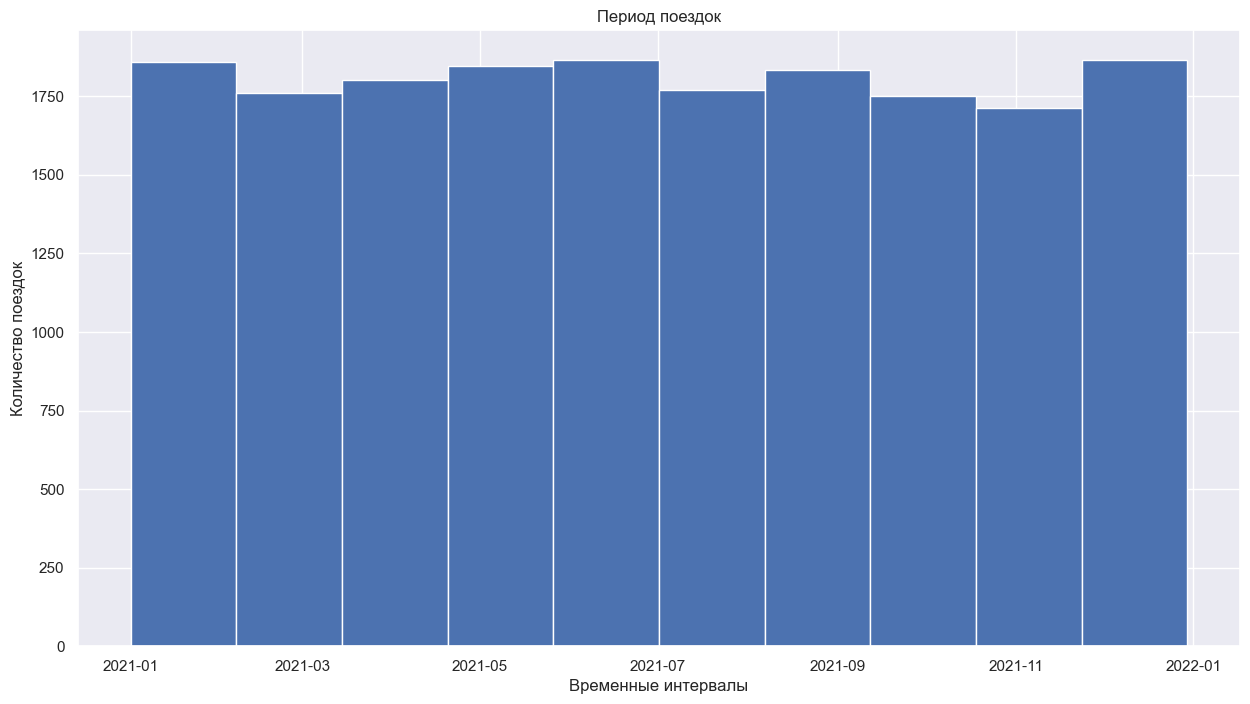

In [16]:
rides_data.hist('date')
plt.title("Период поездок")
plt.xlabel("Временные интервалы")
plt.ylabel("Количество поездок")
plt.show()

Получается, что мы имеем данные по поездкам за 2021 год

Также добавим столбец 'quantity', обозначающий количество поездок, он нам пригодится в дальнейшем.

In [17]:
rides_data['quantity'] = 1
rides_data.head()

,user_id,distance,duration,date,month,quantity
0,1,4409.918945,26,2021-01-01,1,1
1,1,2617.592041,16,2021-01-18,1,1
2,1,754.159790,7,2021-04-20,4,1
3,1,2694.783203,19,2021-08-11,8,1
4,1,4028.687256,27,2021-08-28,8,1


#### Вывод

В рамках предобработки данных проверили данные на предмет пропусков (не обнаружено), устранили дубликаты в количестве 31 строки (из 18068), а также привели данные к оптимальному формату, в частности, 'duration' привели к целочисленному формату, 'date' - к формату Datetime, а для экономии памяти изменили формат столбцов c 64-битного типа на 32-битный.

### Анализ аномальных значений

##### Пользователи:

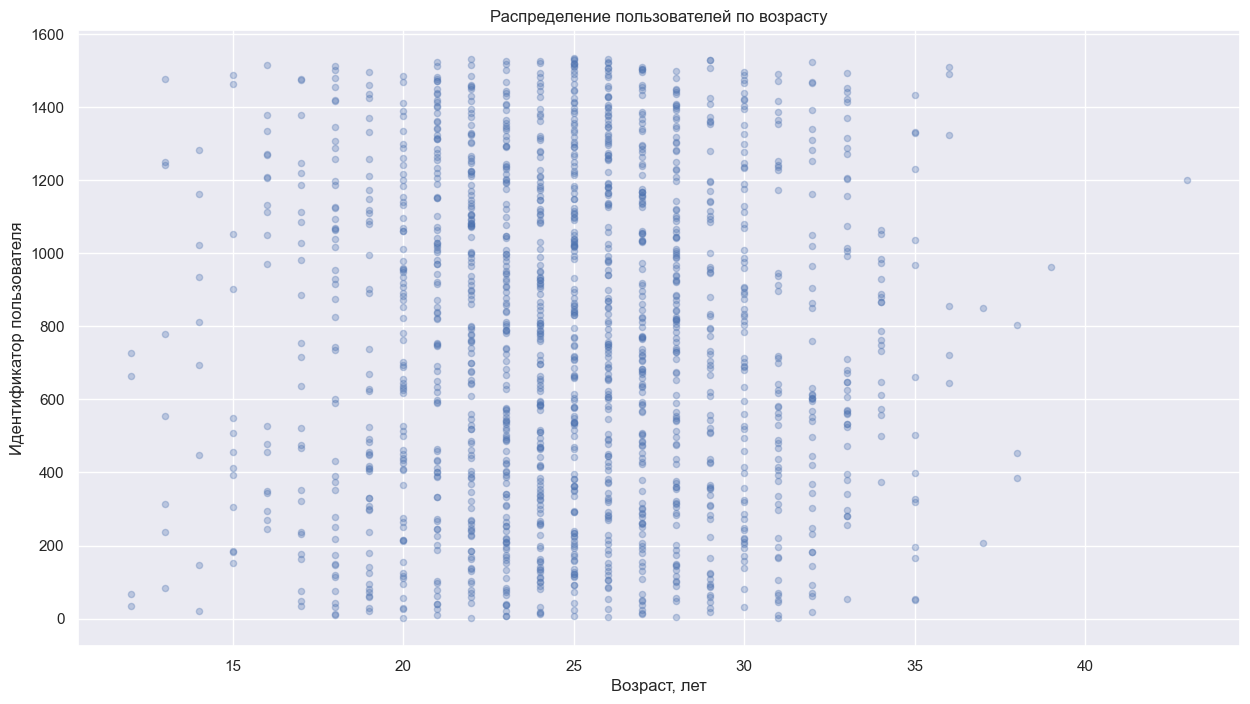

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


In [18]:
users_data.plot(x='age', y='user_id', kind='scatter', alpha=0.3)
plt.title("Распределение пользователей по возрасту")
plt.xlabel("Возраст, лет")
plt.ylabel("Идентификатор пользователя")
plt.show()
users_data.describe()

Очевидных выбросов не наблюдается, посмотрим на следующий датасет.

##### Поездки:

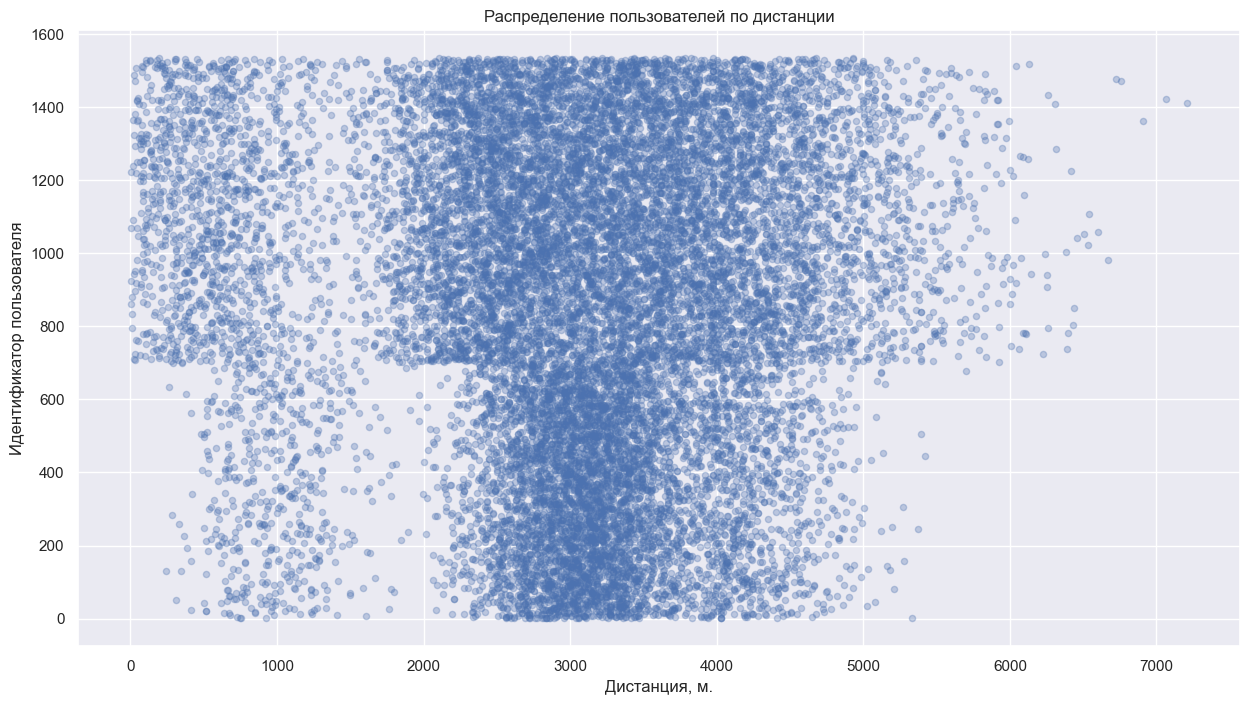

,user_id,distance,duration,month,quantity
count,18068.000000,18068.000000,18068.000000,18068.000000,18068.0
mean,842.869936,3070.660156,18.303520,6.486772,1.0
std,434.734317,1116.832764,6.094928,3.437410,0.0
min,1.000000,0.855683,1.000000,1.000000,1.0
25%,487.000000,2543.226318,14.000000,4.000000,1.0
50%,889.000000,3133.609985,18.000000,6.000000,1.0
75%,1213.250000,3776.222717,22.000000,9.000000,1.0
max,1534.000000,7211.007812,41.000000,12.000000,1.0


In [19]:
rides_data.plot(x='distance', y='user_id', kind='scatter', alpha=0.3)
plt.title("Распределение пользователей по дистанции")
plt.xlabel("Дистанция, м.")
plt.ylabel("Идентификатор пользователя")
plt.show()
rides_data.describe()

Итак, по столбцу 'distance', существенных аномалий не наблюдается, однако необходимо отметить ярко выраженное разделение от 0 до 1,5 км. и от 1,5 км. до 6 км., это может быть связано как с разным типом подписки так и просто разделением между целевой аудиторией сервиса.

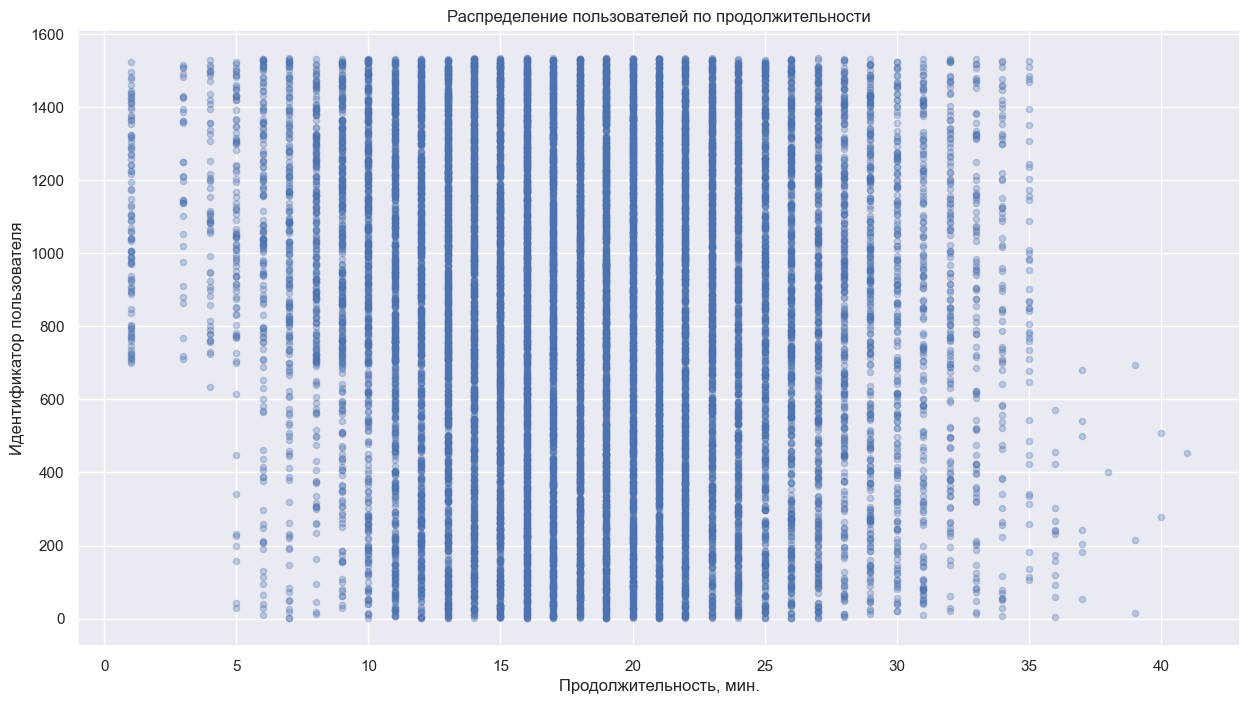

,user_id,distance,duration,month,quantity
count,18068.000000,18068.000000,18068.000000,18068.000000,18068.0
mean,842.869936,3070.660156,18.303520,6.486772,1.0
std,434.734317,1116.832764,6.094928,3.437410,0.0
min,1.000000,0.855683,1.000000,1.000000,1.0
25%,487.000000,2543.226318,14.000000,4.000000,1.0
50%,889.000000,3133.609985,18.000000,6.000000,1.0
75%,1213.250000,3776.222717,22.000000,9.000000,1.0
max,1534.000000,7211.007812,41.000000,12.000000,1.0


In [20]:
rides_data.plot(x='duration', y='user_id', kind='scatter', alpha=0.3)
plt.title("Распределение пользователей по продолжительности")
plt.xlabel("Продолжительность, мин.")
plt.ylabel("Идентификатор пользователя")
plt.show()
rides_data.describe()

Проверим значения около нуля на предмет выбросов:

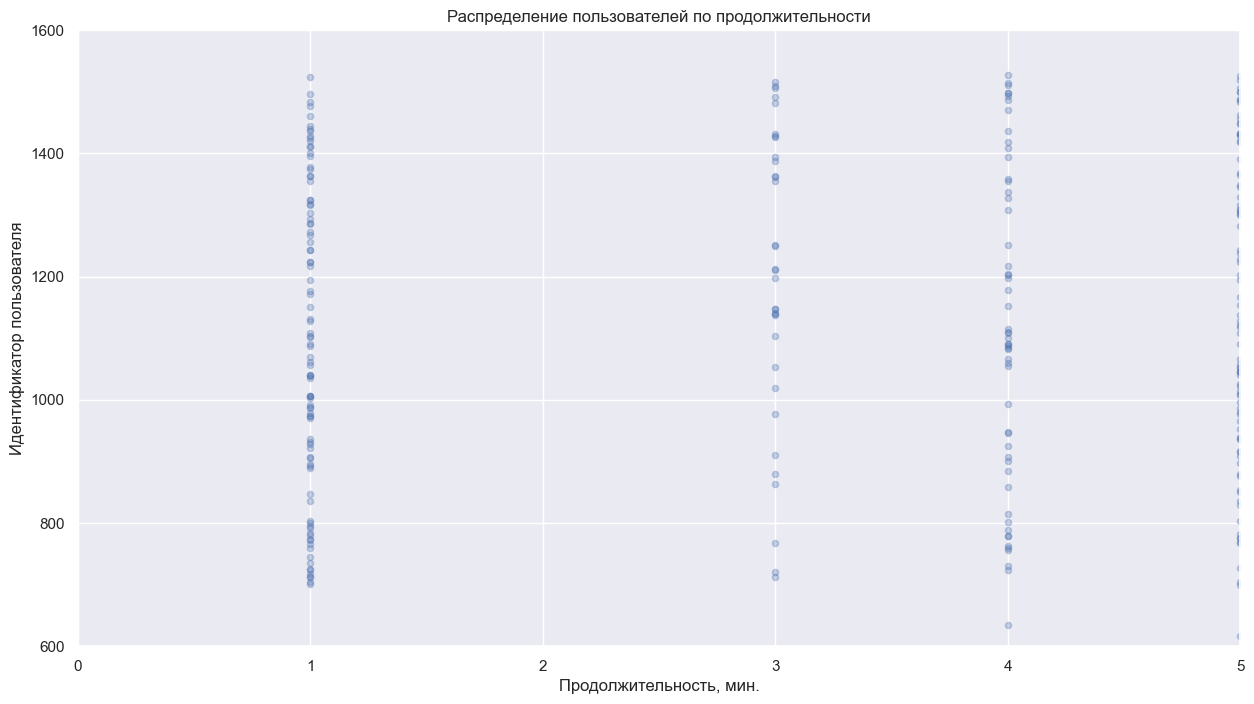

,user_id,distance,duration,month,quantity
count,95.000000,95.000000,95.0,95.000000,95.0
mean,1092.210526,5113.176758,1.0,6.484211,1.0
std,244.028551,658.254150,0.0,3.709858,0.0
min,701.000000,4030.308105,1.0,1.000000,1.0
25%,901.000000,4611.510986,1.0,3.000000,1.0
50%,1069.000000,5052.769531,1.0,6.000000,1.0
75%,1310.500000,5488.459229,1.0,10.000000,1.0
max,1524.000000,7211.007812,1.0,12.000000,1.0


,user_id,distance,duration,month,quantity
count,33.000000,33.000000,33.0,33.000000,33.0
mean,1196.848485,209.395584,3.0,5.848485,1.0
std,240.627451,136.286041,0.0,3.279874,0.0
min,712.000000,11.283615,3.0,1.000000,1.0
25%,1053.000000,102.323624,3.0,3.000000,1.0
50%,1210.000000,181.295471,3.0,6.000000,1.0
75%,1395.000000,292.272705,3.0,9.000000,1.0
max,1516.000000,466.343109,3.0,12.000000,1.0


,user_id,distance,duration,month,quantity
count,55.000000,55.000000,55.0,55.000000,55.0
mean,1118.163636,370.658997,4.0,6.509091,1.0
std,258.639515,203.398987,0.0,3.696208,0.0
min,635.000000,2.570787,4.0,1.000000,1.0
25%,904.000000,234.143265,4.0,3.000000,1.0
50%,1101.000000,336.623688,4.0,6.000000,1.0
75%,1346.500000,564.472351,4.0,10.000000,1.0
max,1528.000000,752.757629,4.0,12.000000,1.0


,user_id,distance,duration,month,quantity
count,95.000000,95.000000,95.0,95.000000,95.0
mean,1053.000000,522.104309,5.0,7.042105,1.0
std,350.413859,273.454865,0.0,3.238452,0.0
min,29.000000,4.329506,5.0,1.000000,1.0
25%,889.000000,313.745026,5.0,5.000000,1.0
50%,1054.000000,514.245605,5.0,7.000000,1.0
75%,1323.500000,692.976990,5.0,10.000000,1.0
max,1525.000000,1310.140869,5.0,12.000000,1.0


In [21]:
rides_data.plot(x='duration', y='user_id', kind='scatter', alpha=0.3, xlim = [0, 5], ylim = [600, 1600])
plt.title("Распределение пользователей по продолжительности")
plt.xlabel("Продолжительность, мин.")
plt.ylabel("Идентификатор пользователя")
plt.show()
display(rides_data.loc[rides_data['duration']== 1].describe())
display(rides_data.loc[rides_data['duration']== 3].describe())
display(rides_data.loc[rides_data['duration']== 4].describe())
display(rides_data.loc[rides_data['duration']== 5].describe())

Все значения длительностью 1 мин являются выбросами, наименьшее расстояние 4 км., наибольшее 7,2 км, при этом время указано некорректно. Оценим существенность данных для принятия дальнейшего решения:

In [22]:
wrong_rides_data=rides_data.loc[rides_data['duration']== 1, 'duration'].count()/rides_data['duration'].count()
print(f'Доля выбросов в общем объеме информации: {wrong_rides_data:.1%}')

Доля выбросов в общем объеме информации: 0.5%


Выбросы составляют пол процента, удаляем.

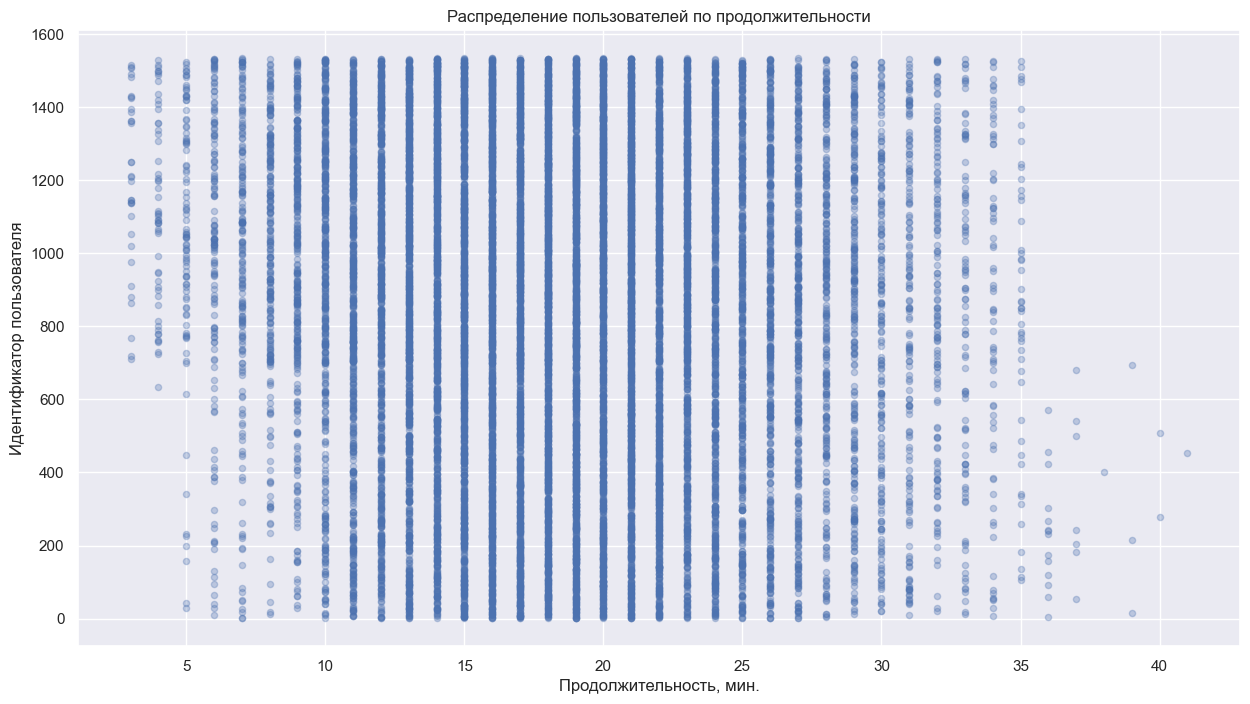

,user_id,distance,duration,month,quantity
count,17973.000000,17973.000000,17973.000000,17973.000000,17973.0
mean,841.551995,3059.863770,18.394981,6.486786,1.0
std,435.144929,1108.815063,5.979419,3.436024,0.0
min,1.000000,0.855683,3.000000,1.000000,1.0
25%,484.000000,2538.839600,14.000000,4.000000,1.0
50%,887.000000,3129.029297,18.000000,6.000000,1.0
75%,1213.000000,3762.636230,22.000000,9.000000,1.0
max,1534.000000,7066.003906,41.000000,12.000000,1.0


In [23]:
rides_data = rides_data.drop(rides_data.loc[rides_data['duration']== 1].index)

rides_data.plot(x='duration', y='user_id', kind='scatter', alpha=0.3)
plt.title("Распределение пользователей по продолжительности")
plt.xlabel("Продолжительность, мин.")
plt.ylabel("Идентификатор пользователя")
plt.show()
rides_data.describe()

#### Вывод

По результатам предварительной обработки исключенный объем информации из датафреймов составляет менее 1%, в связи с чем можно сделать вывод, что представленные для анализа датафреймы достаточно качественные. Данные содержали незначительное количество дубликатов, а также незначительное количество значений без указания корректной длительности поездки, этими данными было решено пожертвовать без ущерба для общего массива данных. В части форматов было решено округлить значения времени поездки и расстояния, поскольку это упростит расчеты и не повлияет на точность расчетов. 

### Исследовательский анализ данных

Для упрощения процесса исследовательского анализа данных напишем функцию для построению гистаграммы по столбцу, диаграммы размаха и вывода описания параметра:

In [24]:
# сделаем словарь для перевода названий колонок на русский
en_names = [
    'user_id',
    'name',
    'age',
    'city',
    'subscription_type',
    'distance',
    'duration',
    'date',
    'month',
    'quantity',
    'minute_price',
    'start_ride_price',
    'subscription_fee'
]

ru_names = [
    'Идентификатор пользователя',
    'Имя',
    'Возраст',
    'Город',
    'Тип подписки',
    'Дистанция',
    'Продолжительность поездки',
    'Дата',
    'Месяц',
    'Количество поездок',
    'Цена за минуту',
    'Стоимость начала поездки',
    'Стоимость ежемесячного платежа'
]

ru_dict = dict(zip(en_names, ru_names))

In [25]:
def research_data(data, col, xlabel, min_range, max_range, bins):
    data.hist(col, range=(min_range,max_range), bins=bins)
    plt.title(f'Гистограмма по показателю "{ru_dict[col]}"')
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.show()
    sns.boxplot(data=data[col], orient='h', linewidth = 1).set(
        ylabel=f'Диаграмма размаха \n по показателю "{ru_dict[col]}"\n',
        xlabel=xlabel
    )
    
    plt.show()
    print(data[col].describe())

#### Частота встречаемости городов

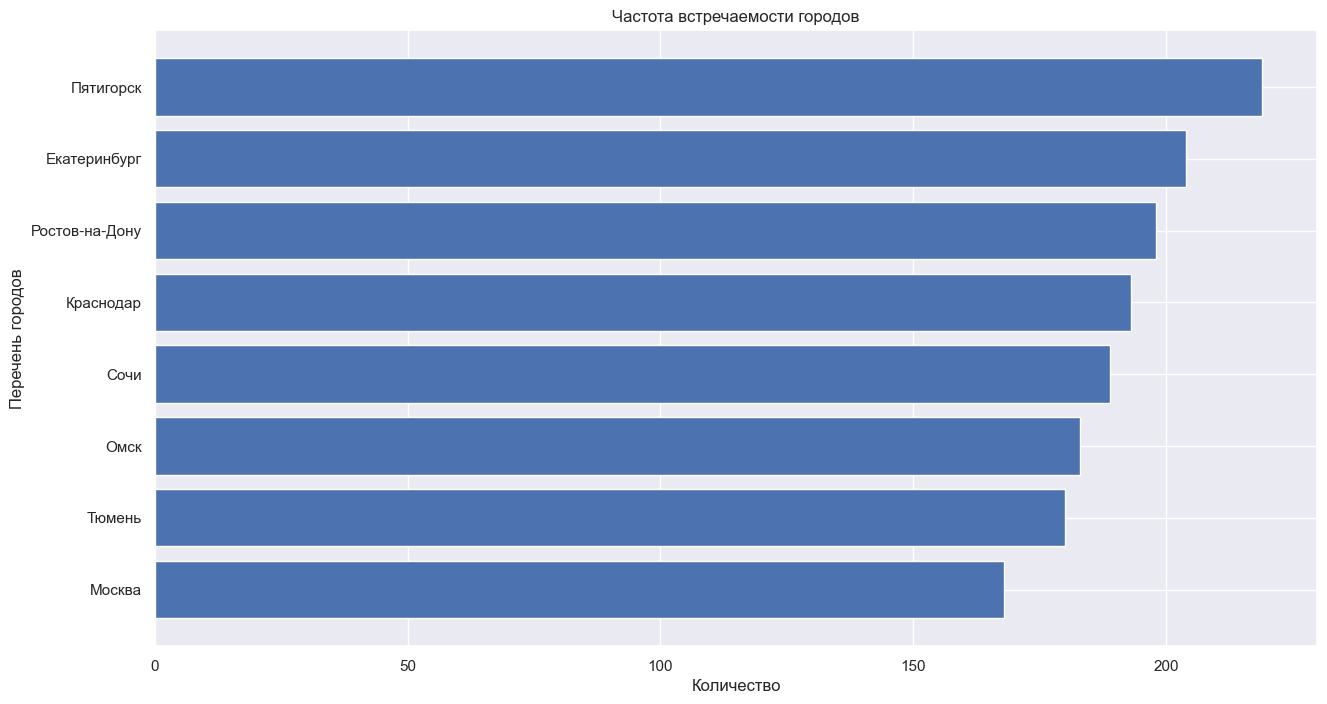

In [26]:
plt.barh(
    users_data['city'].value_counts().sort_values(ascending=True).index,
    users_data['city'].value_counts().sort_values(ascending=True).values
)
plt.title("Частота встречаемости городов")
plt.xlabel("Количество")
plt.ylabel("Перечень городов")
plt.show()

Самыми популярными городами по количеству поездок оказались Пятигорск и Екатеринбург, самым непопулярным Москва (внезапно) и Тюмень. Диаграмму размаха строить нет смысла, она нам в данном случае ничего полезного не покажет.

#### Соотношение пользователей с подпиской и без подписки

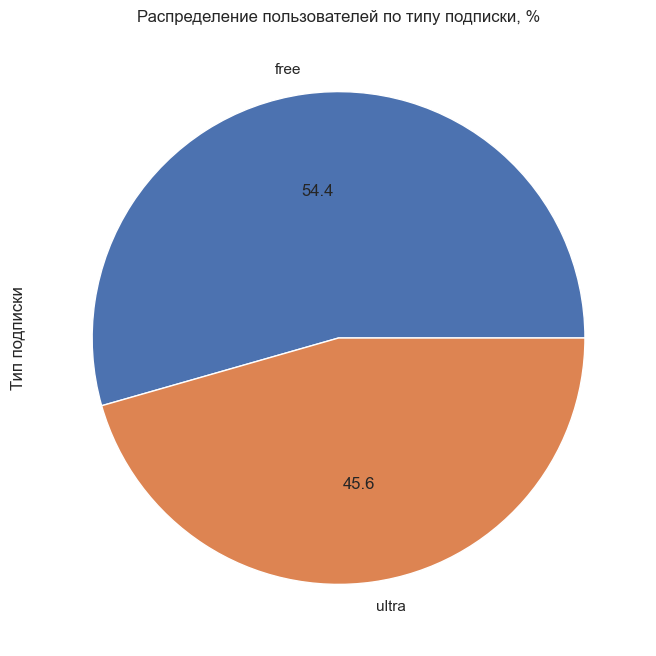

In [27]:
users_data.subscription_type.value_counts().plot(kind='pie', autopct='%.1f',)
plt.title("Распределение пользователей по типу подписки, %")
plt.ylabel("Тип подписки")
plt.show()

Пользователей без подписки действительно больше, однако не на много, всего лишь на 134 человека (8,8%). Подписка пользуется популярностью, можно сказать что она есть чуть ли не у каждого второго.

#### Возраст пользователей

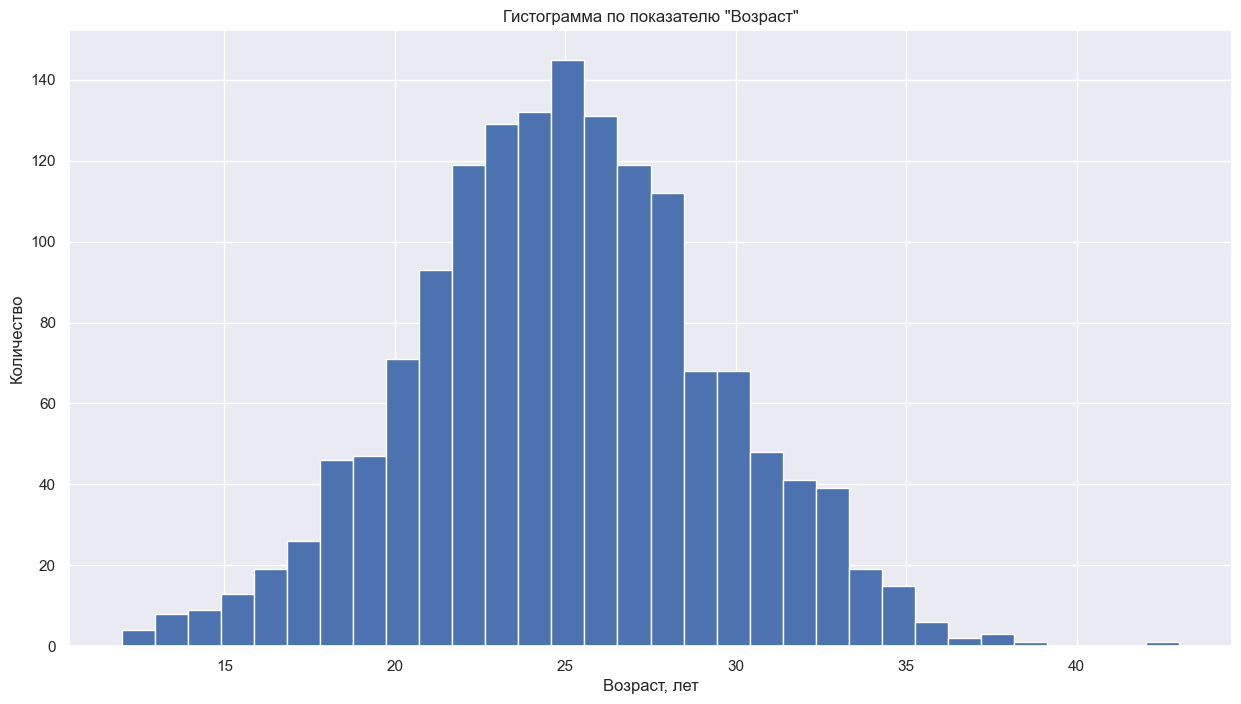

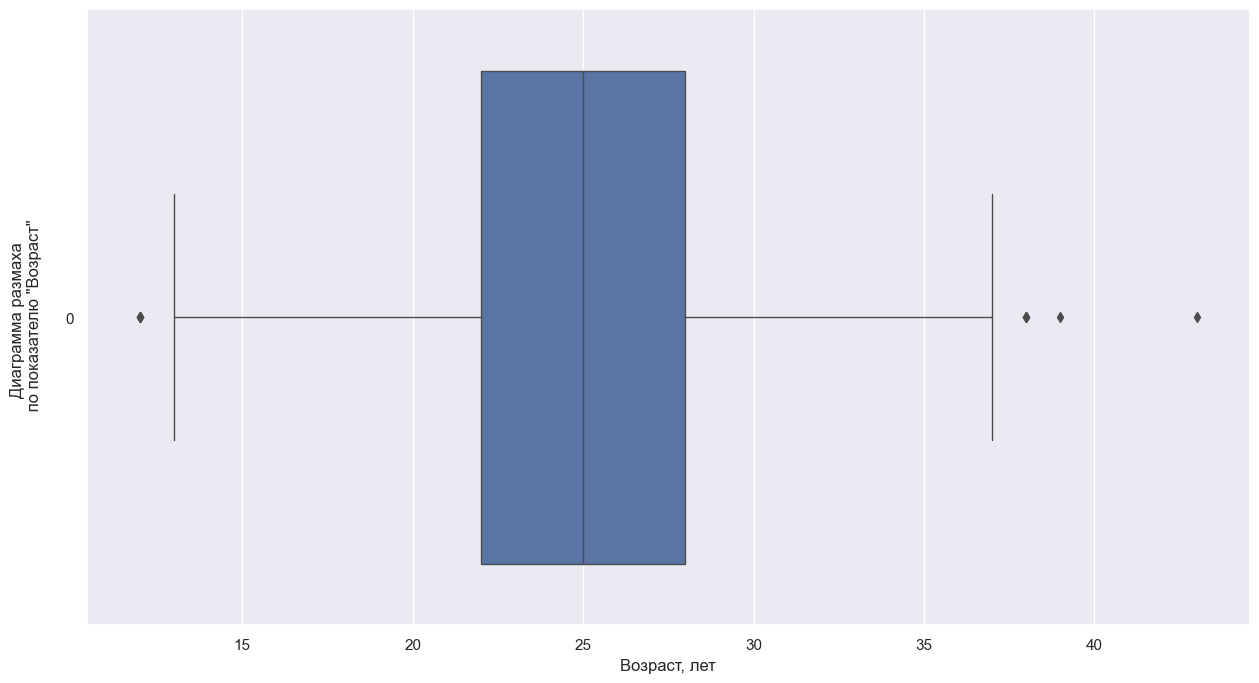

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


In [28]:
research_data(users_data, 'age', 'Возраст, лет', 12, 43, 32)

Возраст распределен 'нормально', средний возраст совпадает с медианным значением в 25 лет. Минимальное значение составляет 12 лет, максимальный возраст - 43. В целом данные находятся в пределах нормы, дополнительных манипуляций в части нормализации не требуется.

#### Расстояние, которое пользователь преодолел за одну поездку

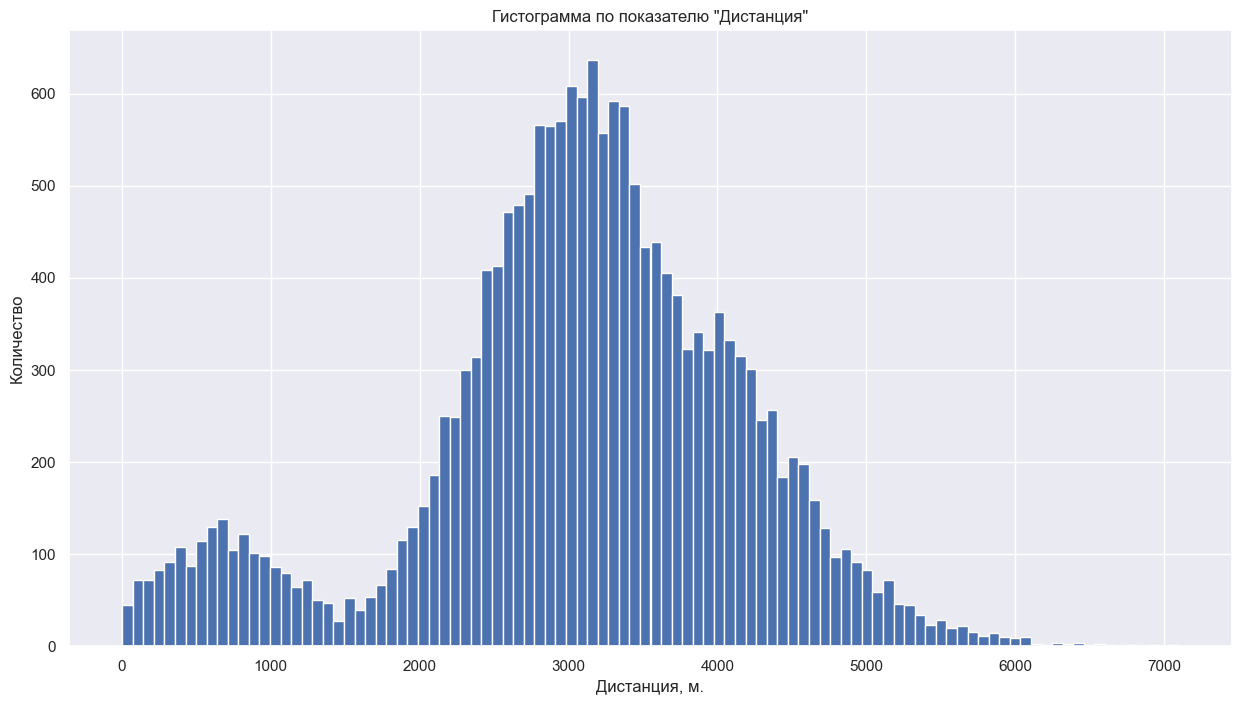

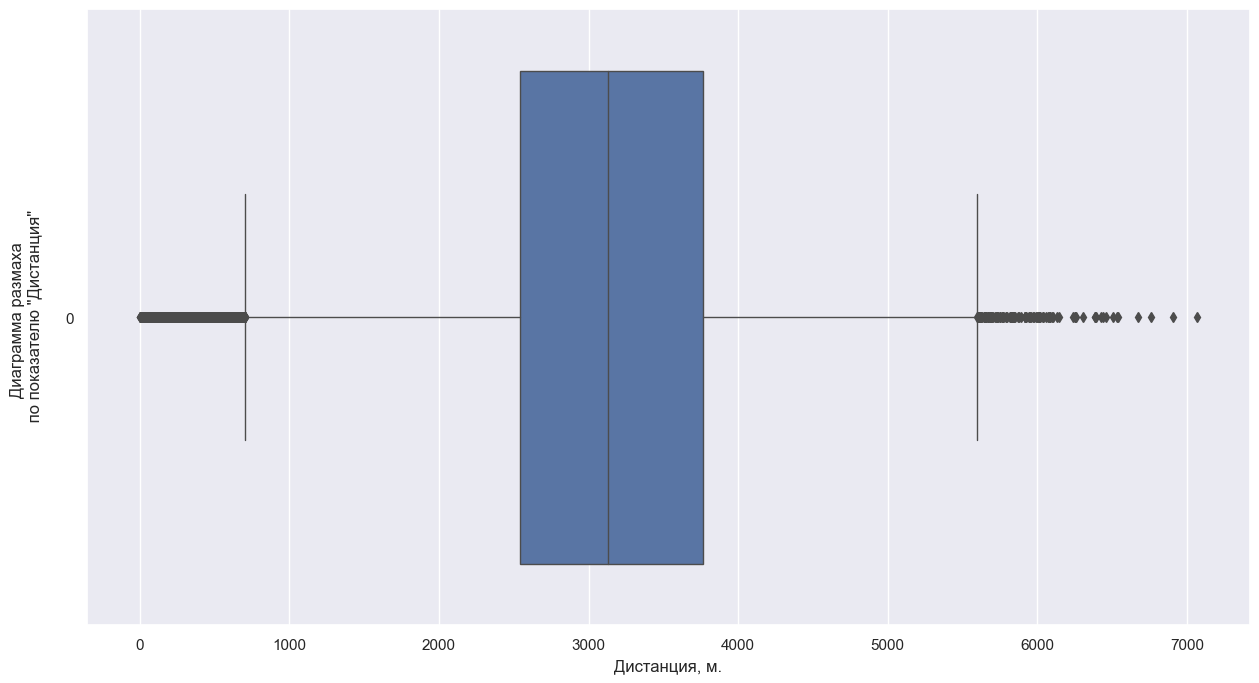

count    17973.000000
mean      3059.863770
std       1108.815063
min          0.855683
25%       2538.839600
50%       3129.029297
75%       3762.636230
max       7066.003906
Name: distance, dtype: float64


In [29]:
research_data(rides_data, 'distance', 'Дистанция, м.', 1, 7100, 100)

На гистограмме видно два распределения, которые мы отмечали ранее. Из текущих данных можно сделать вывод о наличии двух категорий целевой ауддитории с дистанцией до 1,5 км и более 1,5 км. Причины могут быть как в отсутствии/наличии подписки, что делает более длительные поездки выгоднее, либо с особенностями города или периода времени. Подтвердить или опровергнуть данные гипотезы можно будет по результатам объединения датафреймов на дальнейших шагах. Также отмечачем, что медиана и среднее значение достаточно близки относительно друг друга, и находятся в районе 3100 м. Самая длительная поездка составила более 7 км.

#### Продолжительность поездок

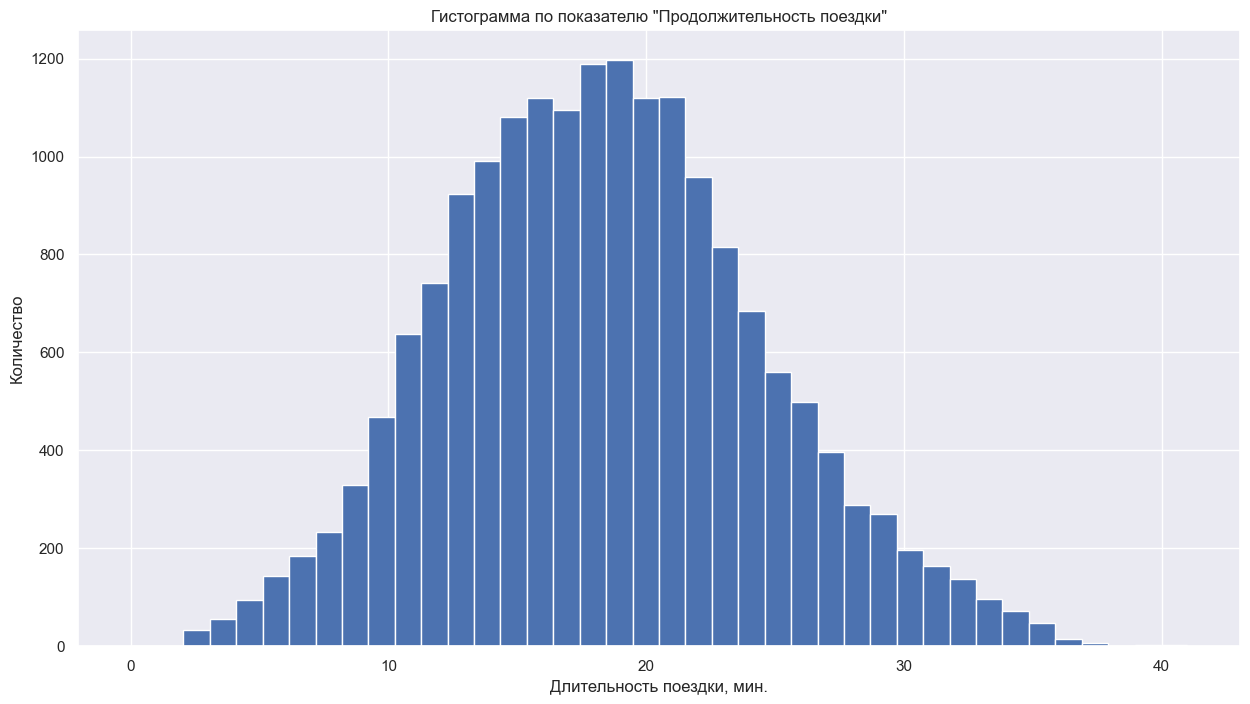

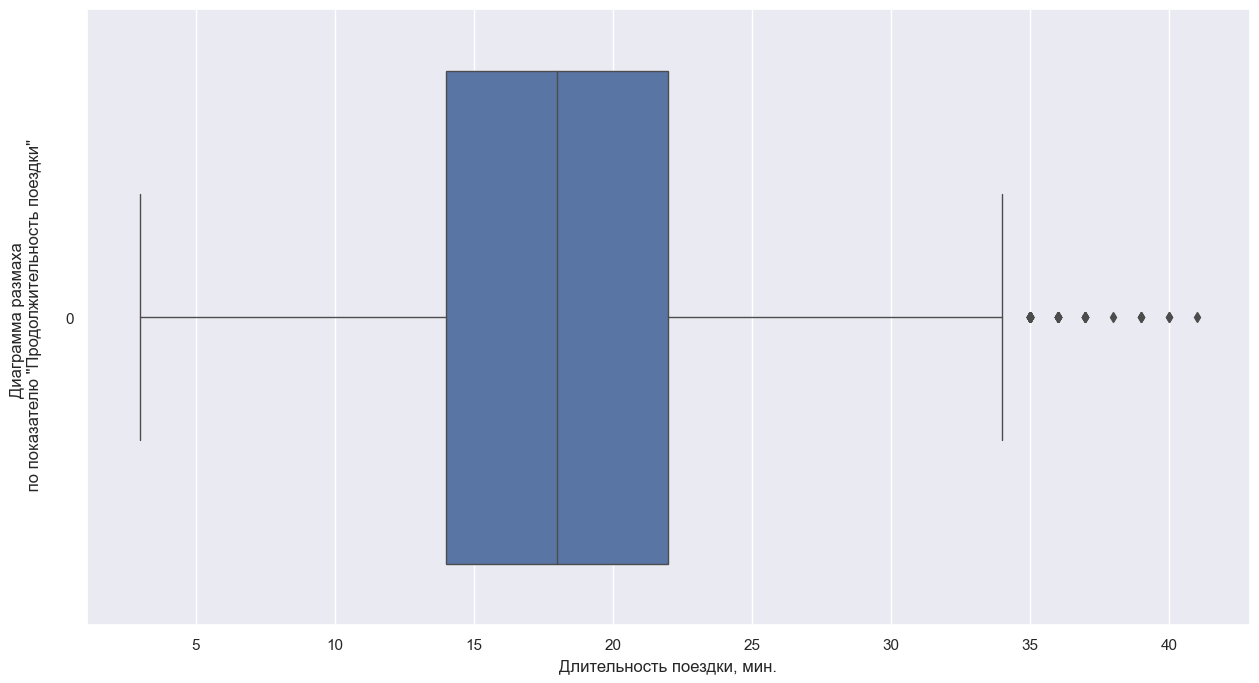

count    17973.000000
mean        18.394981
std          5.979419
min          3.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64


In [30]:
research_data(rides_data, 'duration', 'Длительность поездки, мин.', 0, 41, 40)

Распределение по длительности поездки также демонстрирует 'нормальное' распределение, что говорит нам о том, что выборка сформирована достаточно репрезентативно. Средняя длительность поездки составляет 18 минут, что соответствует медианному значению.

#### Вывод:

По результатам исследовательского анализа данных мы выяснили, что средний возраст пользователя составляет порядка 25 лет, такой пользователь проезжает около 3,1 км примерно за 18 минут. Это соответствует скорости в 10-15 км./час. с учетом остановок, старта и завершения поездки, что в общем и целом соответствует действительности.
Минимальная поездка может составлять порядка минуты с дистанцией около метра, возможно такие случаи бывают когда человек передумал, или решил сменить самокат.
Самая длительная поездка по времени составляет 40 минут, самая длинная дистанция, пройденная на самокате составила более 7 км.

### Объединение данных

#### Объединим данные трех датафреймов, за основу возьмем информацию о поездках:

In [31]:
master_data = rides_data.merge(users_data,  on='user_id', how='left')
master_data = master_data.merge(subs_data,  on='subscription_type', how='left')
master_data

,user_id,distance,duration,date,month,quantity,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.918945,26,2021-01-01,1,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592041,16,2021-01-18,1,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159790,7,2021-04-20,4,1,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783203,19,2021-08-11,8,1,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687256,27,2021-08-28,8,1,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098145,20,2021-11-04,11,1,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423096,22,2021-11-16,11,1,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185547,19,2021-11-18,11,1,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308594,17,2021-11-27,11,1,Альберт,25,Краснодар,free,8,50,0


Проверим не потеряли ли мы данные в результате объединения датафреймов:

In [32]:
print(f'Строк в исходном датафрейме: {rides_data.user_id.count()}')
print(f'Строк в итоговом датафрейме: {master_data.user_id.count()}')

Строк в исходном датафрейме: 17973
Строк в итоговом датафрейме: 17973


Все в порядке.

Создадим ещё два датафрейма из датафрейма из объединенных данных:

- c данными о пользователях без подписки:

In [33]:
free_data = master_data.query('subscription_type == "free"').reset_index(drop=True)
free_data

,user_id,distance,duration,date,month,quantity,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690674,15,2021-01-02,1,1,Айдар,22,Омск,free,8,50,0
1,700,846.932617,17,2021-02-01,2,1,Айдар,22,Омск,free,8,50,0
2,700,4004.434082,21,2021-02-04,2,1,Айдар,22,Омск,free,8,50,0
3,700,1205.911255,10,2021-02-10,2,1,Айдар,22,Омск,free,8,50,0
4,700,3047.379395,18,2021-02-14,2,1,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11468,1534,3781.098145,20,2021-11-04,11,1,Альберт,25,Краснодар,free,8,50,0
11469,1534,2840.423096,22,2021-11-16,11,1,Альберт,25,Краснодар,free,8,50,0
11470,1534,3826.185547,19,2021-11-18,11,1,Альберт,25,Краснодар,free,8,50,0
11471,1534,2902.308594,17,2021-11-27,11,1,Альберт,25,Краснодар,free,8,50,0


- с данными о пользователях с подпиской:

In [34]:
ultra_data = master_data.query('subscription_type == "ultra"').reset_index(drop=True)
ultra_data

,user_id,distance,duration,date,month,quantity,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.918945,26,2021-01-01,1,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592041,16,2021-01-18,1,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159790,7,2021-04-20,4,1,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783203,19,2021-08-11,8,1,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687256,27,2021-08-28,8,1,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046387,25,2021-08-29,8,1,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702637,16,2021-09-12,9,1,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159424,15,2021-09-26,9,1,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845703,16,2021-10-17,10,1,Оксана,22,Москва,ultra,6,0,199


#### Визуализируем информацию о расстоянии и времени поездок:

Данные о расстоянии:

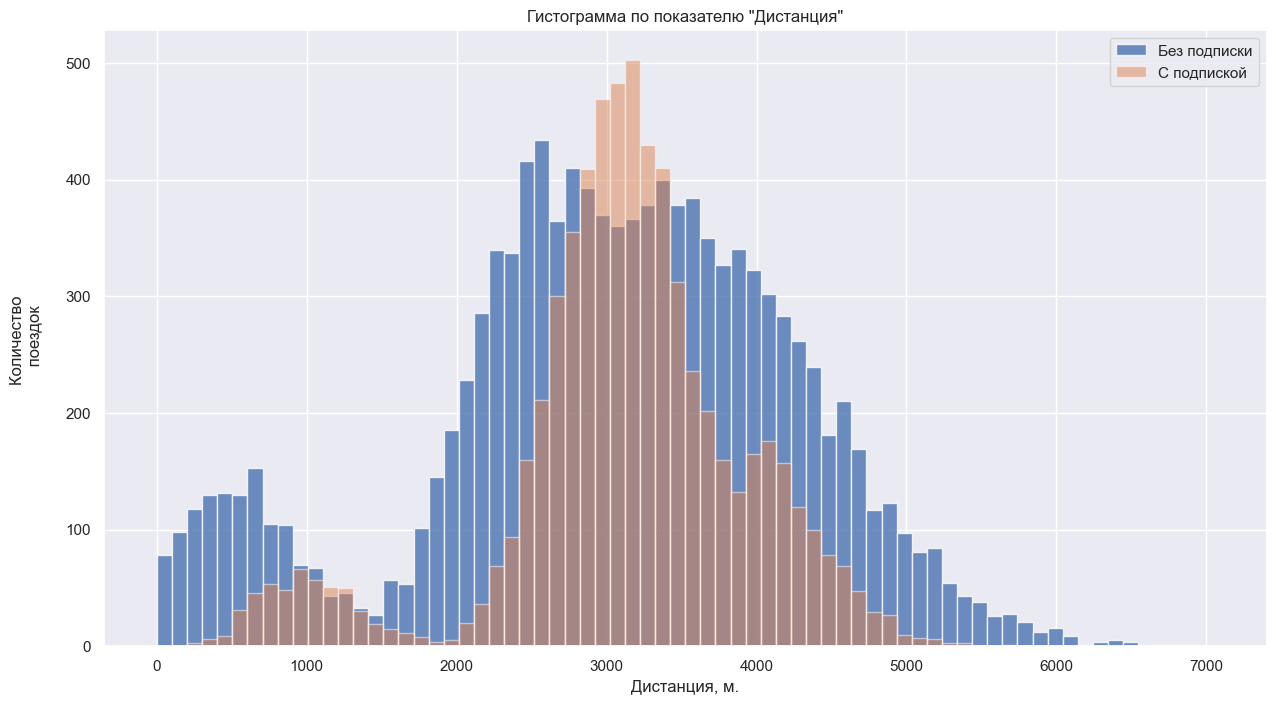

count    11473.000000
mean      3028.374023
std       1235.539673
min          0.855683
25%       2360.878174
50%       3102.083008
75%       3883.979248
max       7066.003906
Name: distance, dtype: float64

count    6500.000000
mean     3115.445557
std       836.894531
min       244.210434
25%      2785.444092
50%      3148.637207
75%      3560.574524
max      5699.769531
Name: distance, dtype: float64


In [35]:
plt.hist(
    free_data['distance'],
    alpha = 0.8,
    label='Без подписки',
    range=(0,7050),
    bins=70
)

plt.hist(
    ultra_data['distance'],
    alpha = 0.5,
    label='С подпиской',
    range=(0,7050),
    bins=70
)


plt.legend(loc='upper right')
plt.title('Гистограмма по показателю "Дистанция"')
plt.xlabel('Дистанция, м.')
plt.ylabel('Количество \n поездок\n')
plt.show()

print(free_data.distance.describe())
print()
print(ultra_data.distance.describe())

Данные о времени поездки:

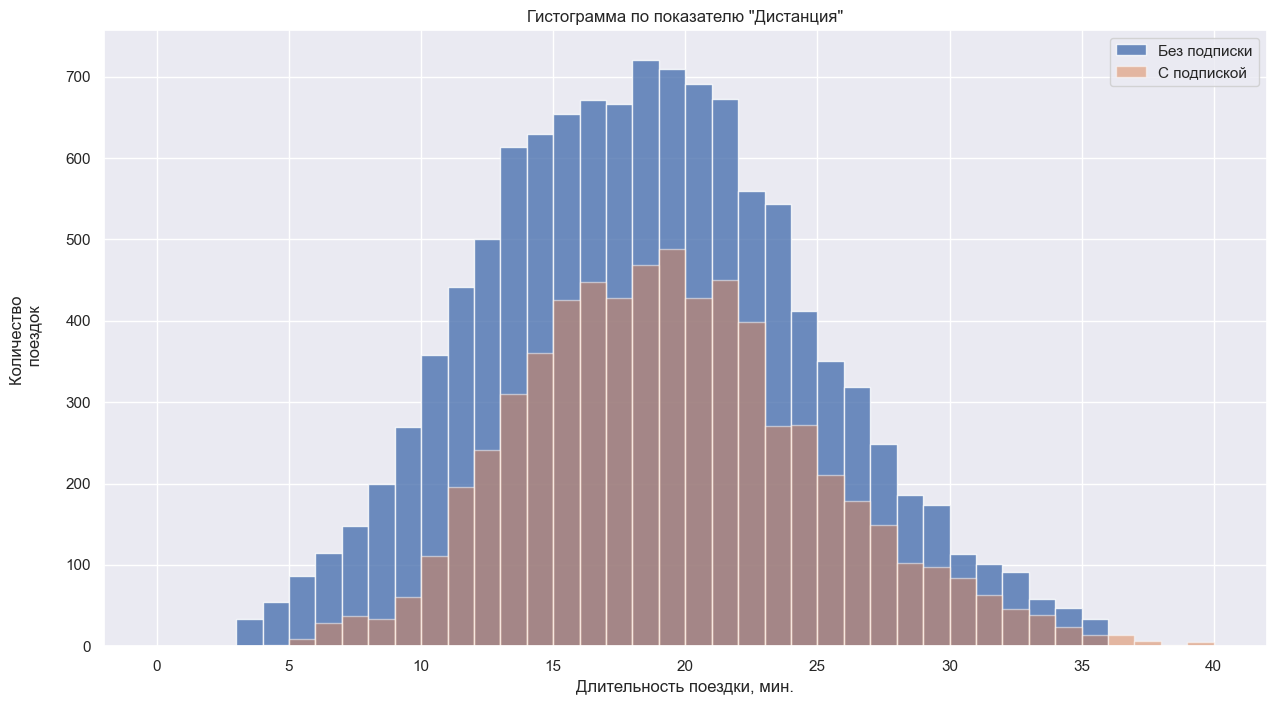

count    11473.000000
mean        18.030855
std          6.166175
min          3.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64


In [36]:
plt.hist(
    free_data['duration'],
    alpha = 0.8,
    label='Без подписки',
    range=(0,40),
    bins=40
)

plt.hist(
    ultra_data['duration'],
    alpha = 0.5,
    label='С подпиской',
    range=(0,40),
    bins=40
)


plt.legend(loc='upper right')
plt.title('Гистограмма по показателю "Дистанция"')
plt.xlabel('Длительность поездки, мин.')
plt.ylabel('Количество \n поездок\n')
plt.show()

print(free_data.duration.describe())
print()
print(ultra_data.duration.describe())

#### Вывод:

На основе визуализации можно сделать несколько логических выводов. Первый, паттерн пройденной дистанции с подпиской очень схож с паттерном без подписки, за одним исключением, с подпиской длительные поездки сильно выделяются из общей массы, в то время как без подписки распределение длительных поездок более равномерное. Второе, с точки зрения длительности поездок, можно сказать что разницы не наблюдается, фигуры практически идентичны, разница между ними сформирована исключительно за счет разного числа позльзователей и как следствие количества поездок той или иной категории.

### Подсчёт выручки

#### Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [37]:
user_pmonth = master_data.pivot_table(
    index = ['user_id', 'month', 'subscription_type'],
    values = ['distance','quantity','duration'],
    aggfunc = 'sum').reset_index()
user_pmonth

,user_id,month,subscription_type,distance,duration,quantity
0,1,1,ultra,7027.510742,42,2
1,1,4,ultra,754.159790,7,1
2,1,8,ultra,6723.470703,46,2
3,1,10,ultra,5809.911133,32,2
4,1,11,ultra,7003.499512,56,3
...,...,...,...,...,...,...
11295,1534,6,free,3409.468506,26,2
11296,1534,8,free,7622.453125,48,2
11297,1534,9,free,4928.173828,23,1
11298,1534,11,free,13350.015625,78,4


#### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [38]:
user_pmonth = user_pmonth.merge(subs_data,  on='subscription_type', how='left')
user_pmonth['revenue'] = \
user_pmonth['subscription_fee'] + \
user_pmonth['start_ride_price'] * user_pmonth['quantity'] + \
user_pmonth['minute_price'] * user_pmonth['duration']
user_pmonth

,user_id,month,subscription_type,distance,duration,quantity,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,ultra,7027.510742,42,2,6,0,199,451
1,1,4,ultra,754.159790,7,1,6,0,199,241
2,1,8,ultra,6723.470703,46,2,6,0,199,475
3,1,10,ultra,5809.911133,32,2,6,0,199,391
4,1,11,ultra,7003.499512,56,3,6,0,199,535
...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,free,3409.468506,26,2,8,50,0,308
11296,1534,8,free,7622.453125,48,2,8,50,0,484
11297,1534,9,free,4928.173828,23,1,8,50,0,234
11298,1534,11,free,13350.015625,78,4,8,50,0,824


Таким образом при помощи pivot_table мы сгруппировали данные по пользователям и вычислили суммарное расстояние, количество поездок, и суммарное время пользователей в разрезе месяцев, а также посчитали выручку, которую принес каждый из пользователей в конкретный месяц.

### Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки?

Проверим гипотезу о том, что пользователи с подпиской тратят на поездки больше времени.
Нулевая гипотеза: средние значения продолжительности из двух групп равны.
Альтернативная гипотеза: среднее значение продолжительности поездки с подпиской больше, чем среднее значение без подписки.

In [39]:
# Создадим равные выборки из двух датасетов:
free_sample = free_data.sample(n=6500)
ultra_sample = ultra_data.sample(n=6500)

alpha = 0.05

duration_results = st.ttest_ind(
    ultra_sample.duration,
    free_sample.duration,
    alternative='greater'
)

print(f'p-value: {duration_results.pvalue}')

# Проверяем p-value:
if duration_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print()
print('Среднее время без подписки: ', free_sample.duration.mean())
print('Среднее время c подпиской: ', ultra_sample.duration.mean())

p-value: 8.195763238130145e-26
Отвергаем нулевую гипотезу

Среднее время без подписки:  17.961384615384617
Среднее время c подпиской:  19.037692307692307


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Можно сделать вывод, что пользователи с подпиской тратят на поездки больше времени. Далее проверим гипотезу о том, приносят ли пользователи с подпиской доход больше чем без.

#### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
Нулевая гипотеза: средние значения расстояния пользователей с подпиской за одну поездку равно 3130 м.
Альтернативная гипотеза: пользователи с подпиской в среднем проезжают больше 3130 м.

In [40]:
interested_value = 3130

alpha = 0.05

distance_results = st.ttest_1samp(ultra_data.distance, interested_value, alternative='greater')
print('p-значение:', distance_results.pvalue)

if (distance_results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: расстояние значимо меньше 3130 м.')
else:
    print('Не получилось отвергнуть нулевую гипотезу: расстояние достигает 3130 м.')


p-значение: 0.9195344662352914
Не получилось отвергнуть нулевую гипотезу: расстояние достигает 3130 м.


Полученное значение p-value больше заданного уровня значимости, поэтому можно утверждать что пользователи с подпиской проезжают в среднем более чем 3130 м. за одну поездку.

#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Проверим гипотезу о том, что пользователи с подпиской оставляют больше денег в приложении.
Нулевая гипотеза: средние значения трат пользователей из двух групп равны.
Альтернативная гипотеза: среднее значение трат пользователей с подпиской больше, чем среднее значение трат пользователей без подписки.

In [41]:
# Разделим датафрейм на два обособленных датафрейма:
free_total = pd.DataFrame(
    user_pmonth.query(
        'subscription_type == "free"'
    ).reset_index(drop=True))

ultra_total = pd.DataFrame(
    user_pmonth.query(
        'subscription_type == "ultra"'
    ).reset_index(drop=True))

# Создадим равные выборки из датасета с выручкой:
free_total_sample = free_total.sample(n=4000)
ultra_total_sample = ultra_total.sample(n=4000)

alpha = 0.05

revenue_results = st.ttest_ind(
    ultra_total_sample.revenue,
    free_total_sample.revenue,
    alternative='greater'
)

print(f'p-value: {revenue_results.pvalue}')

# Проверяем p-value:
if revenue_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

print() 
print('Средняя выручка без подписки: ', free_total.revenue.mean())
print('Средняя выручка c подпиской: ', ultra_total.revenue.mean())

p-value: 1.6770989199530254e-24
Отвергаем нулевую гипотезу

Средняя выручка без подписки:  329.3326437121324
Средняя выручка c подпиской:  362.7921906022502


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания полагать, что пользователи с подпиской тратят больше денег.

#### Какой тест понадобился бы для проверки гипотезы о том, что по результатам обновления сервера, количество обращений в техподдержку значимо снизилось?

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

**Ответ:**

Поскольку в данном случае речь идет не о зависимых (парных) выборках (поскольку мы не можем обеспечить размер и порядок измеряемых объектов), для проверки нам понадобится проведение одностороннего теста с использованием scipy.stats.ttest_1samp().
Для проверки необходимо рассчитать среднее значение обращений в тех. поддержку, которое будет служить эталоном, а в качестве аргумента используем alternative='less'.
Таким образом, если по результатам pvalue будет меньше приемлемого, в данном случае, уровня статистической значимости, то будет основание полагать что количество обращений уменьшилось.

#### Вывод:

По результатам проверки гипотез можно сделать вывод о том, что пользователи с подпиской действительно тратят больше времени и денег на поездки, чем пользователи без подписки. При этом, среднее расстояние, которое они проезжают составляет более 3130 м. Вывод говорит нам о том, что разработанная модель подписки работает. 

### Распределения

#### Вопрос о количестве промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Процент невыполнения плана составит: 4.97%
Количество промокодов составит: 1169


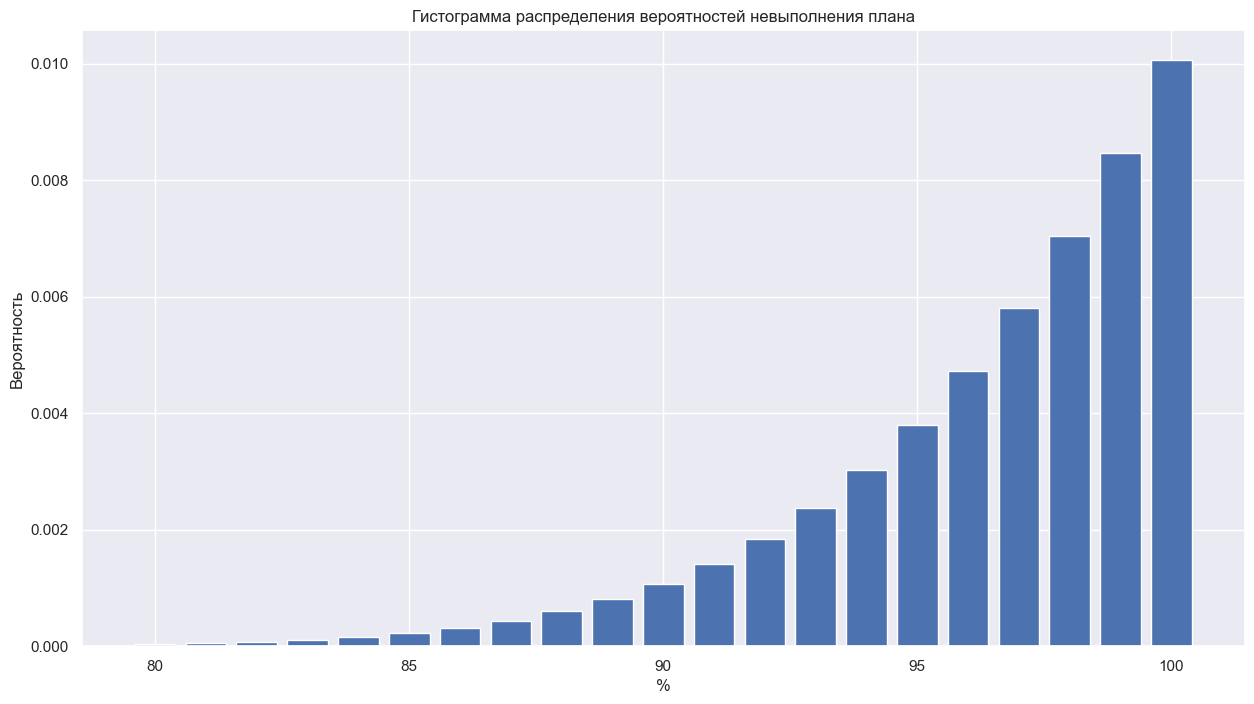

In [42]:
users = 1000 # количество пользователей

while True: 
    users += 1
    p_ext = 0.1 # вероятность успеха
    ext_n = 100 # количество продливших подписку с промокодом
    mu_one = users * p_ext
    sigma_one = sqrt(users * p_ext * (1 - p_ext))
    # задаём нормальное распределение
    distr_one = st.norm(mu_one, sigma_one) 
    # считаем площадь (вероятность) хвоста слева от 100
    result_one = distr_one.cdf(100)
    if result_one < 0.05:
        break

    
print(f'Процент невыполнения плана составит: {result_one:.2%}')
print(f'Количество промокодов составит: {users}')

# визуализируем
distr_hist = []

# заряжаем цикл на проверку условия
for k in range(80, ext_n + 1):
    current_value = binom.pmf(k, users, p_ext)
    distr_hist.append(current_value)
    
plt.bar(range(80, ext_n + 1), distr_hist)
plt.xlabel('%')
plt.ylabel('Вероятность')
plt.title('Гистограмма распределения вероятностей невыполнения плана')
plt.show()

Если сложить вероятности в хвосте графика, получаем около 5%, как и требовалось в задаче. Таким образом, чтобы вероятность не выполнить план была примерно 5 %, нам потребуется 1169 промокодов.

#### Вопрос о вероятности открытия push-уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [43]:
# задаём параметры биномиального распределения
push_n = 1000000
p_open = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu_two = push_n * p_open
sigma_two = sqrt(push_n * p_open * (1 - p_open))

# задаём нормальное распределение
distr_two = st.norm(mu_two, sigma_two) 

# считаем вероятность хвоста слева от 399.5 тысяч
result_two = distr_two.cdf(399500)
print(f'Вероятность того, что уведомление откроют, составит: {result_two:.2%}')

Вероятность того, что уведомление откроют, составит: 15.37%


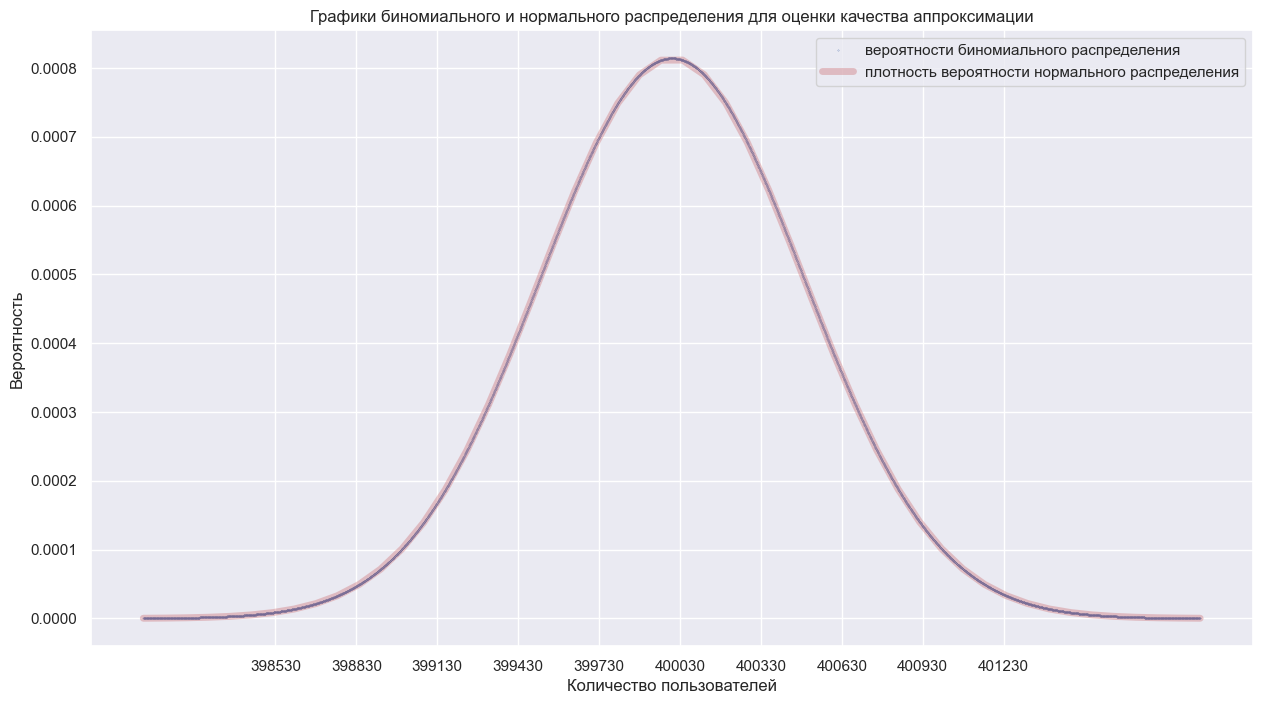

In [44]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(push_n * p_open - 4 * sqrt(push_n * p_open * (1 - p_open)))
right = int(push_n * p_open + 4 * sqrt(push_n * p_open * (1 - p_open)))


# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 0.2
ax.plot(x, binom.pmf(x, push_n, p_open), 'bo', ms=0.2,
        label='вероятности биномиального распределения')

# рисуем график нормального распределения:

# получим список из 50 чисел от left до right
x = linspace(left, right, 50)
# используем красную линию ширины 5 
ax.plot(x, norm.pdf(x, mu_two, sigma_two), 'r-', lw=5, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu_two - 3 * sigma_two), int(mu_two + 3 * sigma_two), 300))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.xlabel('Количество пользователей')
plt.ylabel('Вероятность')
plt.title('Графики биномиального и нормального распределения для оценки качества аппроксимации')
plt.show()

Аппроксимация идеальна из-за большого количества испытаний и вероятности

#### Вывод:

С учетом проведенного исследования, мы определили, что 1169 промокодов обеспечит вероятность успеха на 95%, а при заданных параметрах push-уведомлений вероятность его открытия пользователем составит порядка 49%.

### Итоговый вывод:

В рамках анализа датасетов с информацией о пользователях, поездках и подписках, была осуществлена предварительная обработка данных, а именно, приведение столбцов к надлежащему формату и исключены дублирующие строки.  В части форматов было решено округлить значения времени поездки и расстояния, поскольку это позволило упростить расчеты, а исключенный объем информации из датафреймов составляет менее 1% и не повлиял на точность расчетов. Анализ данных на предмет наличия пропущенных значений и аномалий, подтвердил высокое качество представленной информации.

По результатам исследовательского анализа данных мы выяснили, что средний возраст пользователя составляет порядка 25 лет, такой пользователь проезжает около 3,1 км примерно за 18 минут. Это соответствует скорости в 10-15 км./час. с учетом остановок, старта и завершения поездки, что в общем и целом соответствует действительности. Минимальная поездка может составлять порядка минуты с дистанцией около метра, возможно такие случаи бывают когда человек передумал, или решил сменить самокат. Самая длительная поездка по времени составляет 40 минут, самая длинная дистанция, пройденная на самокате составила более 7 км.

Также в рамках проекта было произведено объединение данных из исходных датафреймов, была подсчитана выручка от каждого пользователя по каждому месяцу, а также суммарное расстояние, количество поездок и длительность поездок. Данные расчеты легли в основу данных для проверки гипотез.

По результатам проверки гипотез мы сделали вывод, что есть основания полагать, что пользователи с подпиской тратят больше времени и денег на поездки, чем пользователи без подписки. При этом, среднее расстояние, которое они проезжают составляет более 3130 м. Вывод говорит нам о том, что разработанная компанией модель подписки работает.

На завершающем этапе исследования, с применением биномиального распределения мы определили, что 1169 промокодов обеспечит вероятность успеха на 95%, а при заданных параметрах push-уведомлений вероятность его открытия пользователем составит порядка 49%.